In [18]:
pwd

'/mmfs1/data/bergerar/BC-MRI-ADHD/Code'

In [19]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from make_models import get_MRI_CVAE_3D
from tqdm import tqdm 
import tensorflow as tf

In [20]:
stuff = np.load('../Assets/brain_array-440.npz')
print(list(stuff.keys()))

data = stuff['data']
control = stuff['controls']
patients = stuff['patients']
n = data.shape[0]
print(data.shape)
data[patients,:,:,:].shape
data[patients].shape

['data', 'controls', 'patients']
(440, 64, 64, 64)


(179, 64, 64, 64)

In [21]:
# data loader
class cvae_data_loader_adhd():
    ''' this is the info'''
    def __init__(self,data,patients,batch_size=32):
    
        self.data = data
        
        self.n = data.shape[0]
        self.epoch = -1
        self.batch_size = batch_size
        
        self.new_epoch()
        self.n_batches = int(np.floor(min((len(self.adhd_idxs),len(self.td_idxs)))/self.batch_size)) # How many batches fit, take the min(n_ADHD,n_TD) then divide by batch size
        
    def new_epoch(self):

        self.adhd_idxs = np.nonzero(patients==True)[0] # idxs of patients
        self.td_idxs = np.nonzero(patients==False)[0] # idxs of TDs
        
        self.adhd_idxs = np.random.permutation(self.adhd_idxs)
        self.td_idxs = np.random.permutation(self.td_idxs)
        
        self.epoch += 1
        self.b = 0
        
        
    def get_batch(self):
        self.b += 1
        
        if self.b==self.n_batches:
            self.new_epoch()
        
        self.batch_adhd_idx = self.adhd_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_td_idx = self.td_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        # go through the patients and controls in batch size chunks
        # batch_indeces = all_indices[batch number * batch size : batch number * batch size + batch size]
        
        self.batch_adhd = self.data[self.batch_adhd_idx,:,:,:]
        self.batch_td = self.data[self.batch_td_idx,:,:,:]
        
        _,counts = np.unique(np.hstack((self.batch_adhd_idx,self.batch_td_idx)),return_counts=True)
        assert all(counts==1),'not all unique, somethings wrong'
        
        return self.batch_adhd,self.batch_td

In [22]:
data_loader = cvae_data_loader_adhd(data,patients)

In [23]:
#tf.__version__

In [24]:
#tf.test.gpu_device_name()

In [25]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

In [26]:
# Make sure you have GPU enabled

n_epochs = 10000
n_batches = data_loader.n_batches # dataloader calcs how many batches
loss = []
for epoch in tqdm(range(n_epochs)):
    for batch in range(n_batches):
        if np.mod(epoch, 100) == 0:
            cvae.save_weights('/mmfs1/data/bergerar/tf_weights_10000_AB/cvae_weights') 
        adhd_batch, td_batch = data_loader.get_batch()
        l = cvae.train_on_batch([adhd_batch,td_batch])
        loss.append(l)
        if np.mod(epoch, 100) == 0:
            np.save('loss_10000_epochs_AB', np.array(loss))


100%|███████████████████████████████████| 10000/10000 [5:45:38<00:00,  2.07s/it]


In [27]:
#import numpy as np
#epoch = 100
#if np.mod(epoch, 100) == 0:
   # cvae.save_weights('/mmfs1/data/bergerar/tf_weightsAB/cvae_weights') 
   # print("save weights")
            

In [28]:
# predictions = cvae.predict([adhd_batch,td_batch])

NameError: name 'predictions' is not defined

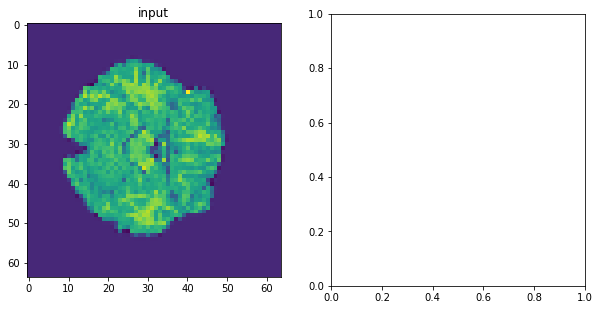

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(adhd_batch[0,:,:,32])
plt.title('input')
plt.subplot(1,2,2)
plt.imshow(predictions[0][0,:,:,32,0])
plt.title('prediction')

In [ ]:
# batch_loss = cvae.train_on_batch([adhd_batch,td_batch])

In [ ]:
# from matplotlib import pyplot as plt
# plt.plot(loss)

In [ ]:
# Save the weights
#cvae.save_weights('/mmfs1/data/bergerar/tf_weightsAB/cvae_weights') 


In [ ]:
# from rsa_funcs import fit_rsa,make_RDM,get_triu

In [ ]:
# symptoms = np.random.rand(100)
# latent_shared = np.random.rand(100)
# latent_specific = np.random.rand(100)

In [ ]:
# symptom_similarity = make_RDM(symptoms)
# shared_similarity = make_RDM(latent_shared)
# specific_similarity  = make_RDM(latent_specific)

In [ ]:
# plt.imshow(symptom_similarity)

In [ ]:
# fit_rsa(symptom_similarity,shared_similarity)

In [ ]:
# fit_rsa(symptom_similarity,specific_similarity)